In [1]:
import pandas as pd
import json
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 
import random

2022-08-05 08:29:48.279042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-05 08:29:48.279065: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
ip = str(json.load(open('/home/onos/Downloads/flask_SDN/config.json'))['ip_local'])
file_name = str(ip).split('.')[-1] + '_lstm'
data = pd.read_csv('/home/onos/Desktop/' + file_name + '.csv')
end = random.randint(81421, 180174)

In [4]:
def _delay(delay, min_delay, max_delay):
    return 1 if min_delay < delay < max_delay else 0
def _LU(LU, min_LU, max_LU):
    return 1 if min_LU < LU < max_LU else 0
def _PL(PL, min_PL, max_PL):
    return 1 if min_PL < PL < max_PL else 0
def _overhead(overhead, max_overhead):
    return 1 if overhead < max_overhead else 0
def get_label(_d, _l, _p, _o):
    kq = _d + _l + _p + _o
    return 1 if kq >=3 else 0
src = list(data['src'].values)
dst = list(data['dst'])
byteReceived = list(data['byteReceived'])
byteSent = list(data['byteSent'])
overhead = list(data['overhead'])
ratio_overhead = list(data['ratio_overhead'])
packetLoss = list(data['packetLoss'])
linkUtilization = list(data['linkUtilization'])
delay = list(data['delay'])
label = list(data['label'])
IpSDN = [ip for i in range(0, end + len(data))]

for i in range (0, end):
    # try:
        ind_ran = random.randint(0, len(data) - 2)
        add_ran = random.randint(-5, 5)
        # print(add_ran)
        src_new = data['src'][ind_ran]
        dst_new = data['dst'][ind_ran]
        byteSent_new = data['byteSent'][ind_ran] + add_ran 
        byteReceived_new = data['byteReceived'][ind_ran] + add_ran

        delay_new = data['delay'][ind_ran] + random.randint(-100, 100)
        delay_new = delay_new if delay_new > 0 else data['delay'][ind_ran]
        linkUtilization_new = data['linkUtilization'][ind_ran] + random.uniform(-0.05, 0.05)
        linkUtilization_new = linkUtilization_new if linkUtilization_new > 0 else data['linkUtilization'][ind_ran]
        packetLoss_new = data['packetLoss'][ind_ran] + random.uniform(-0.05, 0.05)
        packetLoss_new = packetLoss_new if packetLoss_new > 0 else data['packetLoss'][ind_ran]
        overhead_new = ( byteSent_new + byteReceived_new ) / 2
        ratio_overhead_new = ((overhead_new * 2) - 0.35)/0.35
        ratio_overhead_new = 0 if ratio_overhead_new < 0.35 else ratio_overhead_new
        label_new = get_label(_delay(delay_new, 0, 500), _LU(linkUtilization_new, 0.2, 0.75), _PL(packetLoss_new, 0.00, 0.3), _overhead(overhead_new, 35)) 
        src.append(src_new)
        dst.append(dst_new)
        byteSent.append(byteSent_new)
        byteReceived.append(byteReceived_new)
        ratio_overhead.append(ratio_overhead_new)
        overhead.append(overhead_new)
        packetLoss.append(packetLoss_new)
        linkUtilization.append(linkUtilization_new)
        delay.append(delay_new)
        label.append(label_new)
import pandas as pd 

list_of_tuples_test = list(zip(IpSDN,src, dst, byteReceived, byteSent, delay, linkUtilization, overhead, packetLoss, ratio_overhead, label))
    
dataframe = pd.DataFrame(list_of_tuples_test,
                  columns = ['IpSDN','src', 'dst', 'byteReceived', 'byteSent', 'delay', 'linkUtilization', 'overhead', 'packetLoss','ratio_overhead', 'label'])
dataframe.to_csv('/home/onos/Downloads/' + file_name + '.csv')

In [5]:
dataframe

,IpSDN,src,dst,byteReceived,byteSent,delay,linkUtilization,overhead,packetLoss,ratio_overhead,label
0,10.20.0.200,of:0000000000000006,of:0000000000000007,4.274906,10.506868,332,0.000000,7.390887,0.000000,0.000000,0
1,10.20.0.200,of:000000000000002c,of:000000000000002d,8.412595,0.000280,856,0.336515,4.206437,0.000000,0.000000,0
2,10.20.0.200,of:000000000000002c,of:000000000000002d,8.412595,0.000280,856,0.336515,4.206437,0.000000,0.000000,0
3,10.20.0.200,of:000000000000003d,of:000000000000003f,18.924586,18.923776,484,1.000000,18.924181,0.000000,0.000000,0
4,10.20.0.200,of:0000000000000005,of:0000000000000004,8.413157,0.000278,27,0.000000,4.206717,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
127281,10.20.0.200,of:000000000000003c,of:0000000000000003,7.410084,128.039976,50,1.016826,67.725030,0.014855,386.000171,0
127282,10.20.0.200,of:000000000000003c,of:0000000000000003,-2.999246,119.537352,81,1.017637,58.269053,0.040424,331.966017,0
127283,10.20.0.200,of:0000000000000005,of:0000000000000004,-1.999524,81.652096,31,0.000000,39.826286,0.040413,226.578777,0
127284,10.20.0.200,of:000000000000003c,of:0000000000000003,4.000278,122.661816,117,1.025417,63.331047,0.006735,360.891697,0


# Tiền Xử Lý

In [6]:
# dataframe.drop(['_id','byteSent','byteReceived','IpSDN','src', 'dst'], axis=1, inplace=True)
dataframe.drop(['IpSDN', 'src', 'dst', 'byteReceived', 'byteSent'], axis=1, inplace=True)

In [7]:
dataframe

,delay,linkUtilization,overhead,packetLoss,ratio_overhead,label
0,332,0.000000,7.390887,0.000000,0.000000,0
1,856,0.336515,4.206437,0.000000,0.000000,0
2,856,0.336515,4.206437,0.000000,0.000000,0
3,484,1.000000,18.924181,0.000000,0.000000,0
4,27,0.000000,4.206717,0.000000,0.000000,0
...,...,...,...,...,...,...
127281,50,1.016826,67.725030,0.014855,386.000171,0
127282,81,1.017637,58.269053,0.040424,331.966017,0
127283,31,0.000000,39.826286,0.040413,226.578777,0
127284,117,1.025417,63.331047,0.006735,360.891697,0


# Xu ly mat can bang

In [8]:
# Separate majority and minority classes
df_minority = dataframe[dataframe['label'] ==1]
df_majority = dataframe[dataframe['label'] ==0]

print(len(df_minority))
print(len(df_majority))

39837
87449


In [9]:
from sklearn.utils import resample
# Downsample majority class
df_majority = resample(df_majority, 
                                 replace=False,    
                                 n_samples= 60000)

#Upsample minority class
df_minority = resample(df_minority, 
                                 replace=True,     
                                 n_samples= 60000)

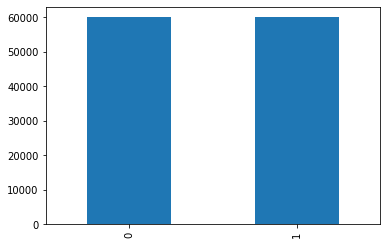

In [10]:
df_up_down_sampled = pd.concat([df_majority, df_minority])
df_up_down_sampled['label'].value_counts().plot(kind='bar')

# Min Max scaler

In [11]:
y = df_up_down_sampled['label']
X = df_up_down_sampled.drop(columns='label')
y_set = y.values
X_set = X.values.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_set = scaler.fit_transform(X_set)


In [12]:
# import sklearn.external.joblib as extjoblib
import joblib
scaler_filename = "/home/onos/Downloads/flask_SDN/scaler.save"
joblib.dump(scaler, scaler_filename) 

['/home/onos/Downloads/flask_SDN/scaler.save']

In [13]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
train_X, test_X, train_y, test_y = train_test_split(X_set, y_set, test_size = 0.3)


# build model

In [14]:
# Thay đổi shape của tập X
time_steps = 1
input_train_lstm = train_X.reshape( train_X.shape[0], time_steps, train_X.shape[1] )

input_test_lstm = test_X.reshape( test_X.shape[0], time_steps, test_X.shape[1])


In [15]:
# #Building the LSTM Model
lstm = Sequential()
# unit = hidden state
lstm.add(LSTM(units=64, input_shape=(time_steps, input_train_lstm.shape[2]), activation='relu', return_sequences=True))

lstm.add(LSTM(units=128, activation='relu', return_sequences=True))

lstm.add(LSTM(units=64, activation='relu', return_sequences=False))


# lop dau vao hinh tron
lstm.add(Dense(1)) 

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
lstm.summary()
file_name = "/home/onos/Downloads/flask_SDN/lstmlocal.hdf5"
checkpoint = ModelCheckpoint(file_name, monitor='accuracy', save_best_only=True, mode='auto', period=1, verbose=1)
# early = EarlyStopping(monitor='accuracy')
epoch=100

from time import time
start = time()

history = lstm.fit(input_train_lstm,
                   train_y,
                   epochs=epoch,
                   verbose=1,
                   callbacks=[checkpoint])
                   
print('Total training time: ', time()-start)

2022-08-05 08:31:18.640507: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-05 08:31:18.640528: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-05 08:31:18.640544: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (onos-virtual-machine): /proc/driver/nvidia/version does not exist
2022-08-05 08:31:18.641214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             17920     
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 166,209
Trainable params: 166,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2613/2625 [============================>.] - ETA: 0s - loss: 0.3815 - accuracy: 0.8441
Epoch 1: accuracy improved from -inf to 0.84445, saving model to /home/onos/Downloa

In [16]:
from keras.utils import plot_model
plot_model(lstm)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


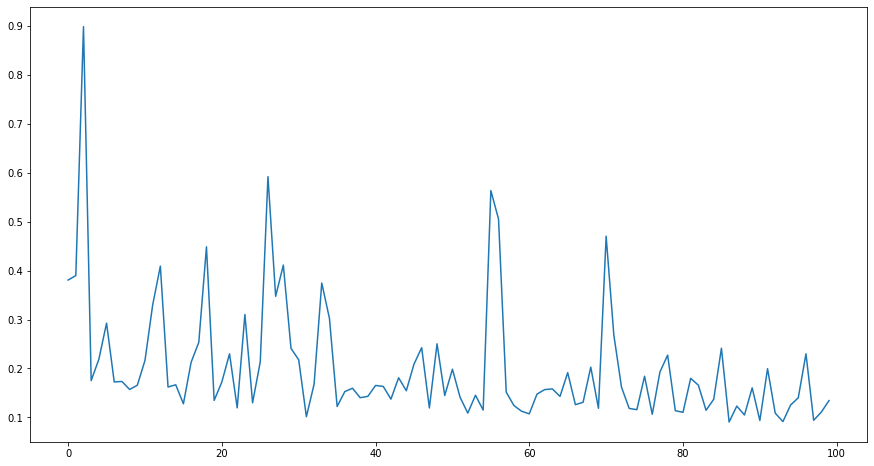

In [26]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(history.history['loss'])
# plt.plot(history.history['accuracy'])
# plt.ylim(0, 1)
# plt.plot(history2.history['val_loss'])

In [27]:
# tap test
predict_lstm_test = lstm.predict(input_test_lstm)

1125/1125 [==============================] - 3s 2ms/step
